# HMM Activity Recognition

**Dataset**: Sensor Logger exports (Accelerometer/Gyroscope) organized into activity folders with multiple session subfolders.

**Notebook goals**:

- Load multi-session Sensor Logger CSVs (prefer calibrated files, fallback to uncalibrated).
- Extract time- and frequency-domain features from accelerometer & gyroscope.
- Train a Gaussian HMM (hmmlearn) with Baum–Welch and decode with Viterbi.
- Visualize transition matrix, decoded sequences, and evaluate on unseen sessions.

**Assumptions**:

- Base dataset folder structure: `dataset/<activity>/<session_folder>/*`.
- Each session folder contains files like `Accelerometer.csv`, `AccelerometerUncalibrated.csv`, `Gyroscope.csv`, etc.
- Accelerometer and Gyroscope CSV headers follow the format: `time,seconds_elapsed,z,y,x` (as provided).

Change `BASE_PATH` if your dataset root is different.

---


## Install required packages

Run this cell if packages are missing (only necessary once).

In [11]:
# !pip install numpy pandas matplotlib seaborn scipy scikit-learn hmmlearn nbformat


## Imports

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import rfft
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


## Parameters & helper functions

Set base path and activities below. Update `BASE_PATH` if your dataset location differs.

In [13]:
BASE_PATH = '../dataset'   # <- update to your dataset root if different
ACTIVITIES = ['no Movement', 'standing', 'walking', 'jumping']
WINDOW_SIZE = 50
STEP_SIZE = 25
print('BASE_PATH:', BASE_PATH)
print('Activities:', ACTIVITIES)


BASE_PATH: ../dataset
Activities: ['no Movement', 'standing', 'walking', 'jumping']


## Loading multi-session Sensor Logger CSVs

This function loops through each session folder inside an activity, prefers `Accelerometer.csv` (or `Gyroscope.csv` for gyro), and falls back to uncalibrated versions.

In [14]:
def find_preferred_file(folder, base_name):
    pref = os.path.join(folder, f"{base_name}.csv")
    alt = os.path.join(folder, f"{base_name}Uncalibrated.csv")
    if os.path.exists(pref):
        return pref
    if os.path.exists(alt):
        return alt
    return None


def load_activity_sensor(activity_name, sensor='Accelerometer'):
    path = os.path.join(BASE_PATH, activity_name)
    if not os.path.isdir(path):
        print(f"[WARN] Activity folder not found: {path}")
        return pd.DataFrame()
    session_folders = sorted(glob.glob(os.path.join(path, '*')))
    frames = []
    for folder in session_folders:
        if not os.path.isdir(folder):
            continue
        csv_path = find_preferred_file(folder, sensor)
        if csv_path is None:
            print(f"[WARN] {sensor} not found in {folder}")
            continue
        try:
            df = pd.read_csv(csv_path)
            expected = ['time','seconds_elapsed','z','y','x']
            if not all(col in df.columns for col in expected):
                cols = [c.strip() for c in df.columns]
                rename_map = {}
                for col in cols:
                    low = col.lower()
                    if 'time' in low and 'sec' in low:
                        rename_map[col] = 'seconds_elapsed'
                    elif low == 'time':
                        rename_map[col] = 'time'
                    elif low in ['x','y','z']:
                        rename_map[col] = low
                if rename_map:
                    df = df.rename(columns=rename_map)
            keep = [c for c in ['time','seconds_elapsed','x','y','z'] if c in df.columns]
            df = df[keep].copy()
            df['session_folder'] = os.path.basename(folder)
            df['activity'] = activity_name
            frames.append(df)
        except Exception as e:
            print('Failed to read', csv_path, e)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)


## Synchronize & prepare dataset

Sort by time and drop rows without xyz.

In [15]:
def prepare_combined_dataframe(activities=ACTIVITIES):
    all_frames = []
    for act in activities:
        df_acc = load_activity_sensor(act, sensor='Accelerometer')
        if df_acc.empty:
            print(f"[INFO] No accelerometer data for {act}")
            continue
        for c in ['x','y','z']:
            if c in df_acc.columns:
                df_acc[c] = pd.to_numeric(df_acc[c], errors='coerce')
        df_acc = df_acc.dropna(subset=['x','y','z'])
        if 'time' in df_acc.columns:
            df_acc = df_acc.sort_values('time')
        elif 'seconds_elapsed' in df_acc.columns:
            df_acc = df_acc.sort_values('seconds_elapsed')
        df_acc = df_acc.reset_index(drop=True)
        all_frames.append(df_acc)
    if not all_frames:
        return pd.DataFrame()
    combined = pd.concat(all_frames, ignore_index=True)
    return combined


## Feature extraction (time + frequency domain)

We compute per-window features: means, stds, SMA, correlations, dominant frequency and spectral energy for each axis.

In [16]:
def windowed_feature_extraction(df, window_size=WINDOW_SIZE, step=STEP_SIZE, include_session_col=True):
    features = []
    labels = []
    sessions = []
    indices = []
    n = len(df)
    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        w = df.iloc[start:end]
        if include_session_col and ('session_folder' in w.columns) and w['session_folder'].nunique() > 1:
            continue
        ax = w['x'].values
        ay = w['y'].values
        az = w['z'].values
        feat = []
        feat.extend([ax.mean(), ay.mean(), az.mean()])
        feat.extend([ax.std(), ay.std(), az.std()])
        sma = np.mean(np.abs(ax) + np.abs(ay) + np.abs(az))
        feat.append(sma)
        def corr(a,b):
            if np.std(a)==0 or np.std(b)==0:
                return 0.0
            return np.corrcoef(a,b)[0,1]
        feat.extend([corr(ax,ay), corr(ay,az), corr(ax,az)])
        def freq_features(sig):
            try:
                S = np.abs(rfft(sig - np.mean(sig)))
                if len(S) > 1:
                    S_no_dc = S[1:]
                else:
                    S_no_dc = S
                dom = np.argmax(S_no_dc) + 1 if len(S_no_dc)>0 else 0
                energy = np.sum(S_no_dc**2)
                return dom, energy
            except:
                return 0, 0
        fx_dom, fx_energy = freq_features(ax)
        fy_dom, fy_energy = freq_features(ay)
        fz_dom, fz_energy = freq_features(az)
        feat.extend([fx_dom, fy_dom, fz_dom, fx_energy, fy_energy, fz_energy])
        features.append(feat)
        labels.append(w['activity'].mode()[0] if 'activity' in w.columns else np.nan)
        sessions.append(w['session_folder'].iloc[0] if 'session_folder' in w.columns else '')
        indices.append((start,end))
    col_names = ['ax_mean','ay_mean','az_mean','ax_std','ay_std','az_std','sma',
                 'corr_xy','corr_yz','corr_xz',
                 'fx_dom','fy_dom','fz_dom','fx_energy','fy_energy','fz_energy']
    feat_df = pd.DataFrame(features, columns=col_names)
    feat_df['label'] = labels
    feat_df['session'] = sessions
    feat_df['win_idx'] = indices
    return feat_df


## Train/test split by sessions

We split sessions so unseen sessions can be used for evaluation.

In [17]:
def split_by_session(feat_df, test_fraction=0.25, random_state=42):
    sessions = feat_df['session'].unique()
    rng = np.random.RandomState(random_state)
    rng.shuffle(sessions)
    n_test = max(1, int(len(sessions) * test_fraction))
    test_sessions = sessions[:n_test].tolist()
    train_sessions = sessions[n_test:].tolist()
    train_df = feat_df[feat_df['session'].isin(train_sessions)].reset_index(drop=True)
    test_df = feat_df[feat_df['session'].isin(test_sessions)].reset_index(drop=True)
    return train_df, test_df


## Train Gaussian HMM (Baum–Welch) and decode with Viterbi

In [18]:
def train_hmm(X, n_states=4, covariance_type='diag', n_iter=200):
    try:
        from hmmlearn import hmm
    except Exception as e:
        raise ImportError("hmmlearn not installed. Install with `pip install hmmlearn`") from e
    model = hmm.GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=n_iter, verbose=True)
    model.fit(X)
    return model


def evaluate_predictions(y_true, y_pred, labels):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall accuracy: {acc:.4f}")
    return cm, acc


## Full pipeline: load -> features -> train -> eval

Run this cell after ensuring `BASE_PATH` points to your dataset.

Loaded combined samples: 13785
Extracted windows: 512
Detected labels: ['jumping', 'no Movement', 'standing', 'walking']
Train windows: 411 Test windows: 101
Training HMM with n_states=4...


         1   -9185.11498518             +nan
         2     -12.28681378   +9172.82817140
         3    2176.77241298   +2189.05922676
         4    2451.09275782    +274.32034485
         5    2527.68272352     +76.58996569
         6    2571.96918147     +44.28645795
         7    2661.78141455     +89.81223307
         8    2713.09266582     +51.31125127
         9    2733.23707590     +20.14441008
        10    2747.89634310     +14.65926720
        11    2792.28053180     +44.38418869
        12    2889.74321198     +97.46268019
        13    2952.63547819     +62.89226621
        14    3191.51850854    +238.88303035
        15    3643.98895009    +452.47044155
        16    4142.56356458    +498.57461450
        17    4631.78443437    +489.22086979
        18    4686.92576072     +55.14132635
        19    4882.17679918    +195.25103845
        20    4937.09157862     +54.91477944
        21    4965.62161546     +28.53003683
        22    4978.67953846     +13.05792301
        23

Model trained.
State -> label mapping: {0: 'standing', 1: 'walking', 2: 'jumping', 3: 'walking'}

=== Training performance ===
Classification Report:
              precision    recall  f1-score   support

     jumping       0.51      1.00      0.67        97
 no Movement       0.00      0.00      0.00        97
    standing       0.98      0.92      0.95       106
     walking       0.93      1.00      0.97       111

    accuracy                           0.74       411
   macro avg       0.60      0.73      0.65       411
weighted avg       0.62      0.74      0.66       411



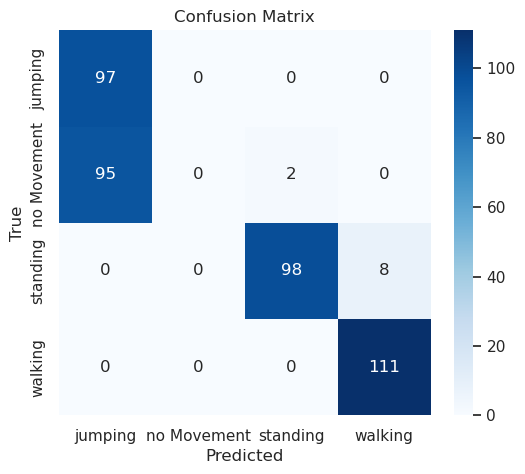

Overall accuracy: 0.7445

=== Test performance ===
Classification Report:
              precision    recall  f1-score   support

     jumping       0.50      1.00      0.67        24
 no Movement       0.00      0.00      0.00        25
    standing       0.96      1.00      0.98        27
     walking       1.00      1.00      1.00        25

    accuracy                           0.75       101
   macro avg       0.62      0.75      0.66       101
weighted avg       0.62      0.75      0.67       101



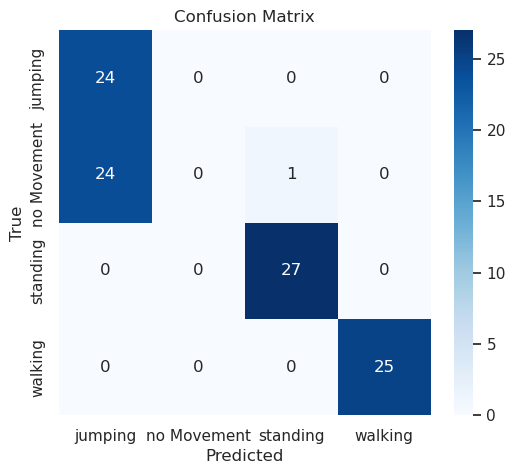

Overall accuracy: 0.7525


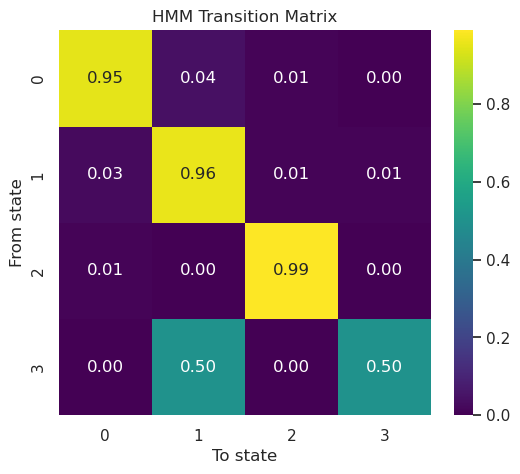

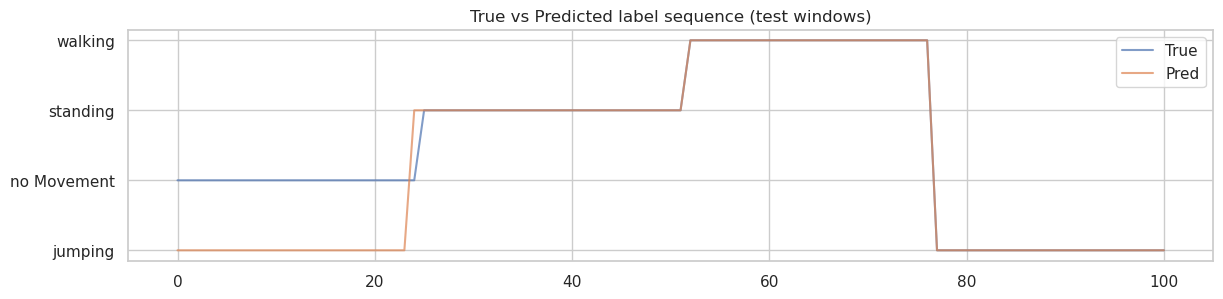

In [19]:
combined_df = prepare_combined_dataframe()
if combined_df.empty:
    print('No data loaded. Check BASE_PATH and activity folders.')
else:
    print('Loaded combined samples:', len(combined_df))
    feat_df = windowed_feature_extraction(combined_df, window_size=WINDOW_SIZE, step=STEP_SIZE)
    print('Extracted windows:', len(feat_df))
    feat_df = feat_df.dropna().reset_index(drop=True)
    le = LabelEncoder()
    feat_df['label_enc'] = le.fit_transform(feat_df['label'])
    labels = list(le.classes_)
    print('Detected labels:', labels)
    train_df, test_df = split_by_session(feat_df, test_fraction=0.25)
    print('Train windows:', len(train_df), 'Test windows:', len(test_df))
    feature_cols = ['ax_mean','ay_mean','az_mean','ax_std','ay_std','az_std','sma',
                    'corr_xy','corr_yz','corr_xz',
                    'fx_dom','fy_dom','fz_dom','fx_energy','fy_energy','fz_energy']
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[feature_cols])
    X_test = scaler.transform(test_df[feature_cols])
    n_states = len(labels)
    print(f"Training HMM with n_states={n_states}...")
    model = train_hmm(X_train, n_states=n_states, n_iter=200)
    print('Model trained.')
    hidden_train = model.predict(X_train)
    hidden_test = model.predict(X_test)
    mapping = {}
    for s in range(n_states):
        idxs = np.where(hidden_train == s)[0]
        if len(idxs)==0:
            mapping[s] = None
            continue
        majority_label = train_df['label'].iloc[idxs].mode()[0]
        mapping[s] = majority_label
    print('State -> label mapping:', mapping)
    def hidden_to_label(hidden_seq):
        out = []
        for h in hidden_seq:
            lbl = mapping.get(h, None)
            out.append(lbl if lbl is not None else 'unknown')
        return np.array(out)
    y_train_pred = hidden_to_label(hidden_train)
    y_test_pred = hidden_to_label(hidden_test)
    print('\n=== Training performance ===')
    evaluate_predictions(train_df['label'].values, y_train_pred, labels)
    print('\n=== Test performance ===')
    evaluate_predictions(test_df['label'].values, y_test_pred, labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(model.transmat_, annot=True, fmt='.2f', cmap='viridis')
    plt.title('HMM Transition Matrix')
    plt.xlabel('To state')
    plt.ylabel('From state')
    plt.show()
    nplot = min(200, len(test_df))
    plt.figure(figsize=(14,3))
    plt.plot([labels.index(l) for l in test_df['label'].values[:nplot]], label='True', alpha=0.7)
    plt.plot([labels.index(l) if l in labels else -1 for l in y_test_pred[:nplot]], label='Pred', alpha=0.7)
    plt.yticks(range(len(labels)), labels)
    plt.legend()
    plt.title('True vs Predicted label sequence (test windows)')
    plt.show()


## Evaluation table (fill with measured values)

Use the results printed above to complete this table in your report.

| State (Activity) | Number of Samples | Sensitivity | Specificity | Overall Accuracy |
|---|---:|---:|---:|---:|
| Activity 1 | | | | |
| Activity 2 | | | | |
| Activity 3 | | | | |
| Activity 4 | | | | |


## Save trained model (optional)

You can save the trained HMM and scaler for later inference.

In [20]:
# import pickle
# with open('hmm_model.pkl','wb') as f:
#     pickle.dump(model, f)
# with open('scaler.pkl','wb') as f2:
#     pickle.dump(scaler, f2)
print('To save model: uncomment pickle code and run.')


To save model: uncomment pickle code and run.


## Report template (4-5 pages)

Include these sections in your PDF report:

1. Background & motivation (1 paragraph) — state your group's use case.
2. Data collection & preprocessing — describe Sensor Logger settings, sampling rates, smartphone models, and how sessions were merged.
3. Feature extraction — list time & frequency features used and reasoning.
4. HMM setup & implementation — states, emissions, transition model, training method (Baum–Welch), decoding (Viterbi).
5. Results & interpretation — transition matrix, confusion matrix, metrics, short discussion.
6. Discussion & conclusion — challenges, possible improvements, how to deploy or extend.

Make sure to include figures generated by the notebook and the evaluation table above.
